In [1]:
cd ../

/Users/ngriffiths/Deep_Learning_Name_Creation


In [352]:
import joblib
import torch
from typing import *
import numpy as np
import torch.nn as nn
import random
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
random.seed(0)

In [153]:
names = list(joblib.load('data/names.pkl')['names'])
chars = set([c for word in names for c in word])
chars.add('!')
names = [n+'!' for n in names]
ix_to_char = {i: c for i, c in enumerate(chars)}
char_to_ix = {c: i for i, c in ix_to_char.items()}

In [158]:
def name_to_ix(name: str,
                   return_y: bool=False
                  ) -> Union[torch.tensor, Optional[torch.tensor]]:
    #x = torch.tensor([char_to_ix[n] for n in name[:-1]])
    x = [char_to_ix[n] for n in name[:-1]]
    y = None
    if return_y:
        y = [char_to_ix[n] for n in name[1:]]
    return x, y

In [161]:
def build_batch(names: List[str], return_y:bool=False):
    x_batch = list()
    y_batch = list()
    
    max_chars = np.max([len(x) for x in names])
    padded_names = [n.ljust(max_chars, '!') for n in names]
    
    
    for name in padded_names:
        x_name, y_name = name_to_ix(name, return_y)
        x_batch.append(x_name)
        y_batch.append(y_name)
    x_batch = torch.tensor(x_batch)
    if return_y:
        y_batch = torch.tensor(y_batch)
        
    return x_batch, y_batch

In [317]:
# Build basic RNN

class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, pad, dropout=.2):
        super(RNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, pad)
        self.rnn = nn.RNN(embed_dim, 20, 2, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(20, vocab_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.embed(x)
        x, h_n = self.rnn(x)
        x = nn.functional.relu(self.fc(x))
        return x.view(x.shape[0], x.shape[2], -1)
        

In [356]:
def train(model,
          optimizer,
          train_names: List[str],
          val_names: List[str],
          batch_size: int= 10,
          criterion=nn.CrossEntropyLoss(),
          n_iter: int=10,
          shuffle: bool=True,
          early_stopping_rounds: int=5,
          model_path = 'models/model.pkl'):
    
    train_groups = len(train_names)//batch_size
    val_groups = len(val_names)//batch_size
    
    train_losses = list()
    val_losses = list()
    
    best_val_loss = np.inf
    no_imp = 0
    
    for it in range(1, n_iter+1):
        
        train_loss = list()
        val_loss = list()
        if shuffle:
            random.shuffle(names)
            
        model.train()
        for i in range(train_groups):
            model.zero_grad()
            x_batch, y_batch = build_batch(train_names[batch_size*i: batch_size*(i+1)], True)

            preds = model(x_batch)

            loss = criterion(preds, y_batch)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            
        model.eval()
        with torch.no_grad():
            for i in range(val_groups):
                x_batch, y_batch = build_batch(val_names[batch_size*i: batch_size*(i+1)], True)
                preds = model(x_batch)
                loss = criterion(preds, y_batch)
                val_loss.append(loss.item())
        
        print(f'Epoch {it} Train Loss: {np.mean(train_loss)}')
        print(f'Epoch {it} Val Loss: {np.mean(val_loss)}')
        train_losses.append(np.mean(train_loss))
        val_losses.append(np.mean(val_loss))
        
        if np.mean(val_loss) < best_val_loss:
            no_imp = 0
            best_val_loss = np.mean(val_loss)
            print('New best score... Saving model... \n')
            torch.save(model.state_dict(), model_path)
        
        else:
            no_imp += 1
            if no_imp == 5:
                print(f'No improvement for {early_stopping_rounds} rounds. Ending training.')
                break
        
    return train_losses, val_losses

In [357]:
model = RNN(vocab_size=len(chars),
            embed_dim=20,
            pad=char_to_ix['!'],
            dropout=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=.005)
random.shuffle(names)
train_names = names[0:round(.7*len(names))]
val_names = names[round(.7*len(names)):]

In [358]:
train_losses, val_losses = train(model=model,
                                 optimizer=optimizer,
                                 train_names=train_names,
                                 val_names=val_names,
                                 batch_size=100,
                                 n_iter=100,
                                 early_stopping_rounds=15
                                 model_path= 'models/basic_rnn.pkl')

Epoch 1 Train Loss: 2.5127486550643465
Epoch 1 Val Loss: 2.352580930620937
New best score... Saving model... 

Epoch 2 Train Loss: 2.338051678395046
Epoch 2 Val Loss: 2.2754401512065177
New best score... Saving model... 

Epoch 3 Train Loss: 2.271811612897276
Epoch 3 Val Loss: 2.227787668422117
New best score... Saving model... 

Epoch 4 Train Loss: 2.2266521496277574
Epoch 4 Val Loss: 2.1871305108070374
New best score... Saving model... 

Epoch 5 Train Loss: 2.195277540252619
Epoch 5 Val Loss: 2.1746303962448894
New best score... Saving model... 

Epoch 6 Train Loss: 2.1837518595229395
Epoch 6 Val Loss: 2.1631388464216457
New best score... Saving model... 

Epoch 7 Train Loss: 2.1736390027951398
Epoch 7 Val Loss: 2.1666265443219976
Epoch 8 Train Loss: 2.1687725049997466
Epoch 8 Val Loss: 2.1515338863356637
New best score... Saving model... 

Epoch 9 Train Loss: 2.165585482215743
Epoch 9 Val Loss: 2.138458063844907
New best score... Saving model... 

Epoch 10 Train Loss: 2.159413883369

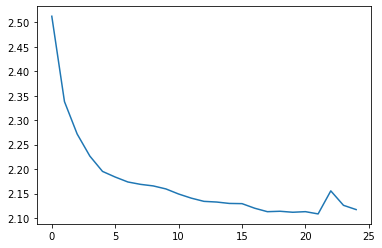

In [359]:
plt.plot(train_losses)

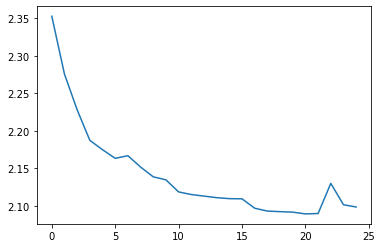

In [360]:
plt.plot(val_losses)